##### Laboratoire 2
# Discrimination linéaire et réseaux de neurones profonds
## Classification et régression (Datasets FER et FG-NET)

### GTI771 - Apprentissage machine avancé
#### Département de génie logiciel et des technologies de l’information (LogTI)

##### <font color=white> Version 1.0 - février 2020<br>Version 2.0 - février 2020 <br> Version 3.0 - mars 2020<br>Version 4.0 - juin 2020 (Richard Rail)<br>Version 4.1 - février 2021<br></font><br>Version 4.2 - février 2022<br>


##### Prof. Alessandro L. Koerich

| Étudiants             | Antoine Brassard Lahey - BRAA05089904 <br/>  Antoine Pelchat-Fortin - PELA04029703 <br/> Sébastien Charbonneau - CHAS01049805               |
|-----------------------|---------------------------------------------------------|
| Session               | ÉTÉ 2022                                                |
| Équipe                | 10                                                      |
| Numéro du laboratoire | 2                                                       |
| Professeur            | Hervé Lombaert                                          |
| Chargé de laboratoire | Lucas Geffard                                           |
| Date                  | 2022-07-12                                              |

# Introduction

Ce deuxième laboratoire porte sur l'utilisation de trois algorithmes d'apprentissage soit les algorithmes de régression, les réseaux neuronaux et les réseaux neuronaux profonds. Dans ce laboratoire, vous êtes amenés à utiliser de nouvelles approches à l’aide de ces algorithmes aﬁn de résoudre deux problèmes: prédiction de l'âge de personnes à partir de photos du visage (régression); problème de classiﬁcation des expressions faciales (FER) introduit dans le cadre du premier laboratoire de ce cours.

Le problème de régression qui vous est présenté est le problème [Facial Aging Estimation (FAE)](https://yanweifu.github.io/FG_NET_data/index.html), dont le but est de prédire l'âge des personnes à partir du visage. En vous basant sur les concepts vus en classe et l'expérience acquise dans le laboratoire 1, vous êtes invité à reprendre les primitives développées lors du laboratoire 1 ou d'autres primitives que vous jugez pertinentes à extraire sur ces types d’images et effectuer l’extraction de celles-ci sur l’ensemble de données fournies avec cet énoncé. 

##### Description de l'ensemble de données:
* 1002 images faciales de 82 sujets multiraciaux âgés de 0 à 69 ans;
* Déséquilibré: 50% des sujets ont entre 0 et 13 ans;
* Images couleur et niveaux de gris avec une dimension moyenne de 384x487 pixels, et la résolution varie de 200 dpi à 1200 dpi;
* Grande variation d'éclairage, de pose, d'expression faciale, de flou et d'occlusions (par exemple, moustache, barbe, lunettes, etc.).

Voici, en exemple, des images de visages se retrouvant dans l’ensemble de données FG-NET:

![Exemples de FER](https://www.mdpi.com/sensors/sensors-16-00994/article_deploy/html/images/sensors-16-00994-g001.png)

Veuillez noter que les images qui vous sont fournies ne sont pas nécessairement similaires aux images de FER. Plusieurs images comportent du bruit, des artéfacts ou des éléments non pertinents. Le défi de ce laboratoire repose sur cette difficulté qui est chose courante dans des problèmes d’apprentissage machine moderne.

Tout comme le premier travail pratique, vous réaliserez ce deuxième laboratoire avec la technologie Python3 conjointement avec la librairie d’apprentissage machine scikit-learn et TensorFlow et Keras pour la partie réseaux de neurones. Vous êtes invité à reprendre le code développé lors du laboratoire 1 afin de continuer son développement.

<font color=black> L’évaluation de ce laboratoire sera basée sur la qualité des modèles entraînés, la comparaison des performances réalisées par les différents modèles, les réponses aux questions dans cette notebook ainsi que l'organisation de votre code source (SVP, n'oubliez pas des commentaires dans le code!).</font>

* #### Partie 1: Régression
* Régression lineaire
* Régression Ridge
* Régression Lasso et Elastic-Net
* Descente du gradiente stochastique (SGD)<br>
<br>
* #### Partie 2: Classification
* Régression logistique
* Réseaux de neurones MLP <br>
<br>
* #### Partie 3: Classification et régression
* Réseaux convolutionel entraîné "from scratch"
* Réseaux convolutionel + modèles pre-entraînes (transfer learning)
* Réseaux convolutionel adapté à la régression

## Partie 0: Imports

#### (0a) Import de bibliotèques



##### À faire:
1. Ajouter toutes les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

In [1]:
# Numpy - Used to manipulate matrices
import numpy as np

# Matplotlib - 2D plotting library
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

# Library to pre-treat images. Used for denoising.
import skimage
from skimage import feature
from skimage.restoration import denoise_tv_chambolle

# SKLearn - Implementations of different machine learning models, used for tuning as well
import absl
import sklearn
import sklearn.metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Used for section 3 (create CNNs)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG19, InceptionResNetV2, EfficientNetV2L
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Dropout, MaxPooling2D, Flatten, RandomFlip, RandomContrast, RandomHeight, Resizing, RandomRotation, RandomBrightness, RandomWidth, RandomZoom
from tensorflow.keras.utils import to_categorical

# OpenCV - Includes functions for computervision. Used for image preprocessing and SIFT implementation.
import cv2

# Used to get float maxvalue
import sys

# Used for file system operations
import os

# Used to write csv datasets
import csv

# Used to manipulate tabular data (dataframes)
import pandas

# Used to save models
import pickle as pkl
import matplotlib.patches as patches

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#### (0b) Fonctions

##### À faire:
Avez-vous créé des fonctions? Si oui, vous devez les mettre ici, avec une description.

In [2]:
def read_FER_csv(input_path, feature_length):
  data = np.loadtxt(input_path, delimiter=',', dtype=str )
  (Xtrain, ytrain) = split_FER_csv(data, 1, 28710, feature_length)
  (Xtest, ytest) = split_FER_csv(data, 28710, 32299, feature_length)
  (Xval, yval) = split_FER_csv(data, 32299, 35888, feature_length)
  return Xtrain, ytrain, Xtest, ytest, Xval, yval

def split_FER_csv(data, start_index, end_index, feature_length):
  X = np.ones((end_index - start_index, feature_length), float)
  
  for i in range(start_index, end_index):
    X[i-start_index] = data[i,1].split(" ")

  y = data[start_index:end_index, 0].astype(int)

  return (X, y)

def eval_model(model, x_train, y_train, x_val, y_val, x_test, y_test, titre):
  # Classification
  ypred_train = model.predict(x_train)
  if not(isinstance(ypred_train[0], np.int32) or isinstance(ypred_train[0], np.int64)):
    ypred_train = np.argmax(ypred_train, axis=1)
        
  training_accuracy = sklearn.metrics.accuracy_score(y_train, ypred_train, normalize=True, sample_weight=None)
  print("Training accuracy: ")
  print(str(training_accuracy * 100) + '%')
  print("Training error: ")
  print(str((1 - training_accuracy) * 100) + '%')

  ypred_val = model.predict(x_val)
  if not(isinstance(ypred_val[0], np.int32) or isinstance(ypred_val[0], np.int64)):
    ypred_val = np.argmax(ypred_val, axis=1)
    
  validation_accuracy = sklearn.metrics.accuracy_score(y_val, ypred_val, normalize=True, sample_weight=None)
  print("Validation accuracy: ")
  print(str(validation_accuracy * 100) + '%')
  print("Validation error: ")
  print(str((1 - validation_accuracy) * 100) + '%')


  ypred_test = model.predict(x_test)
  if not(isinstance(ypred_test[0], np.int32) or isinstance(ypred_test[0], np.int64)):
    ypred_test = np.argmax(ypred_test, axis=1)
    
  test_accuracy = sklearn.metrics.accuracy_score(y_test, ypred_test, normalize=True, sample_weight=None)
  print("Test accuracy: ")
  print(str(test_accuracy * 100) + '%')
  print("Test error: ")
  print(str((1 - test_accuracy) * 100) + '%')

  train_precision = sklearn.metrics.precision_score(y_train, ypred_train, average='micro')
  validation_precision = sklearn.metrics.precision_score(y_val, ypred_val, average='micro')
  test_precision = sklearn.metrics.precision_score(y_test, ypred_test, average='micro')
  avg_precision = (train_precision + validation_precision + test_precision) / 3
  print("Average precision: " + str(avg_precision * 100) + '%')

  # Confusion matrix
  matrice_confusion = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=ypred_test, labels=[i for i in range(0, len(labels))])
  disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=matrice_confusion, display_labels=labels)
  disp.plot()
  plt.title(f'Matrice de confusion - {titre}')
  plt.show()

def eval_regression_model(model, x_train, y_train, x_val, y_val, x_test, y_test, titre):
  # Classification
  ypred_train = model.predict(x_train)
  if not(isinstance(ypred_train[0], np.int32) or isinstance(ypred_train[0], np.int64)):
    ypred_train = np.argmax(ypred_train, axis=1)

  ypred_val = model.predict(x_val)
  if not(isinstance(ypred_val[0], np.int32) or isinstance(ypred_val[0], np.int64)):
    ypred_val = np.argmax(ypred_val, axis=1)

  ypred_test = model.predict(x_test)
  if not(isinstance(ypred_test[0], np.int32) or isinstance(ypred_test[0], np.int64)):
    ypred_test = np.argmax(ypred_test, axis=1)

  mae_train = sklearn.metrics.mean_absolute_error(y_train, ypred_train)
  mse_train = sklearn.metrics.mean_squared_error(y_train, ypred_train)
  r2_train = sklearn.metrics.r2_score(y_train, ypred_train)

  mae_val = sklearn.metrics.mean_absolute_error(y_val, ypred_val)
  mse_val = sklearn.metrics.mean_squared_error(y_val, ypred_val)
  r2_val = sklearn.metrics.r2_score(y_val, ypred_val)

  mae_test = sklearn.metrics.mean_absolute_error(y_test, ypred_test)
  mse_test = sklearn.metrics.mean_squared_error(y_test, ypred_test)
  r2_test = sklearn.metrics.r2_score(y_test, ypred_test)

  print('Training Set')
  print(f'MAE: {mae_train}')
  print(f'MSE: {mse_train}')
  print(f'R2: {r2_train}')
  
  print('Validation Set')
  print(f'MAE: {mae_val}')
  print(f'MSE: {mse_val}')
  print(f'R2: {r2_val}')
  
  print('Test Set')
  print(f'MAE: {mae_test}')
  print(f'MSE: {mse_test}')
  print(f'R2: {r2_test}')



def save_model(model, pkl_name):
    # Save model
    pickle = open(f'Models/{pkl_name}.pkl', 'wb') 
    pkl.dump(model, pickle)
    pickle.close()
    
def convert_to_rgb(Xtrain, Xval, Xtest, width, length):
    Xtrain_rgb = np.zeros((Xtrain.shape[0], width, length, 3))
    Xval_rgb = np.zeros((Xval.shape[0], width, length, 3))
    Xtest_rgb = np.zeros((Xtest.shape[0], width, length, 3))
    
    for i, image in enumerate(Xtrain):
        to_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        Xtrain_rgb[i] = to_rgb
        
    for i, image in enumerate(Xval):
        to_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        Xval_rgb[i] = to_rgb
        
    for i, image in enumerate(Xtest):
        to_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        Xtest_rgb[i] = to_rgb
        
    return Xtrain_rgb, Xval_rgb, Xtest_rgb

def convert_grayscale_to_3_channels(Xtrain, Xval, Xtest, width, length):
    Xtrain_stacked_grayscale = np.zeros((Xtrain.shape[0], width, length, 3))
    Xval_stacked_grayscale = np.zeros((Xval.shape[0], width, length, 3))
    Xtest_stacked_grayscale = np.zeros((Xtest.shape[0], width, length, 3))
    
    for i, image in enumerate(Xtrain):
        stacked_img = np.concatenate((image,)*3, axis=-1)
        Xtrain_stacked_grayscale[i] = stacked_img
    
    for i, image in enumerate(Xval):
        stacked_img = np.concatenate((image,)*3, axis=-1)
        Xval_stacked_grayscale[i] = stacked_img
        
    for i, image in enumerate(Xtest):
        stacked_img = np.concatenate((image,)*3, axis=-1)
        Xtest_stacked_grayscale[i] = stacked_img
        
    return Xtrain_stacked_grayscale, Xval_stacked_grayscale, Xtest_stacked_grayscale

def transfer_train(pre_trained_model, Xtrain, ytrain, Xval, yval):
  for layer in pre_trained_model.layers:
      layer.trainable = False

  transfer_trained_model = Sequential()
  transfer_trained_model.add(pre_trained_model)

  # On ajoute les couches pour la classification
  transfer_trained_model.add(Flatten())
  transfer_trained_model.add(Dense(100, activation='relu'))
  transfer_trained_model.add(Dense(len(labels), activation='softmax'))

  # Training avec images greyscale 3 channels (stacked)
  transfer_trained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  transfer_trained_model.fit(Xtrain, ytrain, epochs=30, batch_size=128, verbose=1, validation_data=(Xval, yval))
  return transfer_trained_model

def augment_data(X, y, shape):
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  
  augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2),
    Resizing(shape[0], shape[0])
  ])

  augmented = []
  for (augmented_image, _) in dataset.map(lambda x, y: (augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE):
    augmented.append(augmented_image.numpy())

  return np.array(augmented)

def create_my_cnn(input_shape, output_shape, output_activation):
  pixel_cnn = Sequential()
  pixel_cnn.add(Conv2D(16, (5, 5), padding='same', input_shape=input_shape, activation='relu'))
  pixel_cnn.add(AveragePooling2D((2, 2), strides=2))

  pixel_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  pixel_cnn.add(AveragePooling2D((2, 2), strides=2))

  pixel_cnn.add(Flatten()),
  pixel_cnn.add(Dense(120, activation='relu'))
  pixel_cnn.add(Dropout(0.3))
  pixel_cnn.add(Dense(84, activation='relu'))
  pixel_cnn.add(Dropout(0.3))
  pixel_cnn.add(Dense(output_shape, activation=output_activation))
  return pixel_cnn

def pretreat_fgnet(X):
  X_pretreated = []

  for image in X:
      image = image / np.max(image)
      image = skimage.restoration.denoise_tv_bregman(image)
      image = cv2.resize(image, (48, 48)).reshape((48, 48, 1))
      X_pretreated.append(image)
  
  return np.array(X_pretreated)

def print_regression_results(regressionName,regression_obj, y_pred, y_test):
    # The coefficients
    print("---  "+str(regressionName)+" ---\n")
    print("Coefficients: \n", regression_obj.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
    print("--------------------------")

# Partie 1: Explorez les algorithmes de régression
## FG-NET dataset (Facial Aging Estimation)

Dans cette partie vous devez explorer les <b> algorithmes de régression linéaire </b> disponibles dans Scikit-learn, comme régression least square, régression Ridge, régression Lasso et Elastic-Net, descente du gradient stochastique (SGD), etc.

Vous devez comparer la performance de ces algorithmes pour l'ensemble de données FG-NET sur:

1. Le vecteur de pixels (images vectorisées)
2. Vecteur de primitives (reprendre l'algorithme d'extraction de primitives que vous avez utilisées dans le Laboratoire 1, p.ex. LBP). Vous pouvez reprendre les primitives "réduits" que vous avez utilisées dans le Laboratoire 1 (p.ex. vecteur LBP après PCA), si vous pensez qu’ils sont plus performants.

### 1a: Charger le fichier de données

In [7]:
# Load data
X_fgnet = np.loadtxt('Datasets/fgnet_256x256.csv', delimiter=',', dtype=int )
y_fgnet = np.loadtxt('Datasets/fgnet_labels.csv', delimiter=',', dtype=int )

X_fgnet = X_fgnet.reshape(X_fgnet.shape[0], 256, 256)

### 1b: Visualisation des visages

Vous pouvez visualiser les images en utilisant `plt.imshow`.

Il y a différents types de prétraitement que nous pouvons appliquer à des images dans les ensembles de données pour réduire la variabilité, réduire des bruits, etc.

Voici deux sources pour vous aidez à décider:
- http://eprints.qut.edu.au/92300/1/manuscript_Jhony.pdf
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7475805

### À faire:
1. Pensez-vous qu’est nécessaire un prétraitement des images? Si oui, vous pouvez choisir différents algorithmes de prétraitement dans [scikit-image](https://scikit-image.org/docs/stable/api/api.html). Il y a aussi autres types de prétraitement plus généraux dans [scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing).
2. Expliquer et justifier les prétraitements choisis.

#### Code

In [8]:

X_fgnet = pretreat_fgnet(X_fgnet)

#### Résultats et réponses

Pour notre pré-traitement, nous effectué trois traitements.

D'abord, nous avons utilisé les images en résolution 256x256. Nous avons normalisé les pixels des images entre 0 et 1. Nous espérons que cela permettra une meilleur performance des modèles.

Nous avons aussi remarqué que plusieurs des images ont été prises sur film. Le film utilisé fait un effet de bruit dans les images. Nous avons testé plusieurs techniques de réduction du bruit offertes par skimage. Nous avons décidé d'appliquer la fonction qui donnait, visuellement, les meilleurs résultats: denoise_tv_bregman.

Nous avons ensuite réduit la résolution des images à 48x48.

### 1c: Statistiques sur les sujets et étiquettes

##### À faire:
1. Calculer quelques statistiques (# images par sujet, distribution des âges, etc.) que vous jugez importantes sur les données
2. Faire une analyse des résultats et présenter vos conclusions basées sur ces statistiques.

#### Code:

Statistics of Trainning data


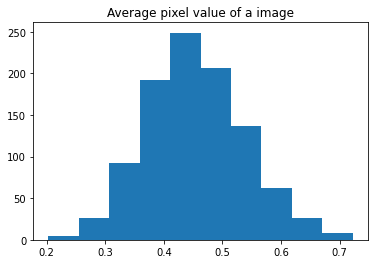

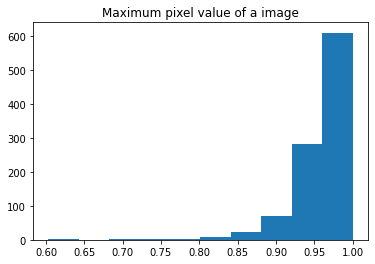

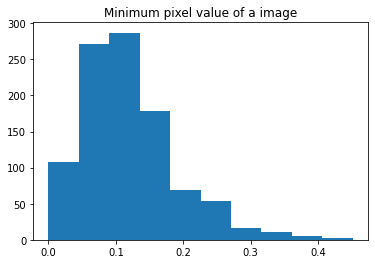

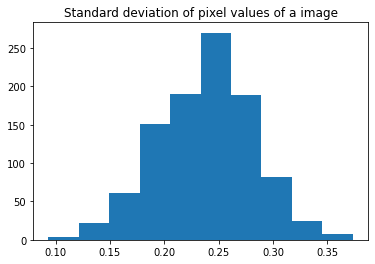

In [9]:
# Votre code ici
maxlist = []
minlist = []
averagelist = []
st_devlist = []
nb_images = 0;

for img in X_fgnet:
    img = img.reshape(2304)
#     print("--------")
#     print(img.shape)
#     print(img[nb_images].shape)
    averagelist.append(sum(img)/len(img))
    maxlist.append( np.max(img))
    minlist.append(np.min(img))
    st_devlist.append( np.std(img))
    
# print(averagelist) 
# print(averagelist[0])
# print(averagelist[2])
# print(averagelist[3])

# Code exemple:
# Histogramme des étiquettes (classes)
hist, _ = np.histogram(y_fgnet, density=False, bins=7, range=(0, 7))

print("Statistics of Trainning data")
plt.hist(averagelist)
plt.title('Average pixel value of a image')
plt.show()
plt.hist(maxlist)
plt.title('Maximum pixel value of a image')
plt.show()
plt.hist(minlist)
plt.title('Minimum pixel value of a image')
plt.show()
plt.hist(st_devlist)
plt.title('Standard deviation of pixel values of a image')
plt.show()
# Code exemple:
# Histogramme des étiquettes
#hist, _ = np.histogram(ytrain, density=False, bins=7, range=(0, 7))

#### Résultats et réponses:

In [ ]:
# Vos résultats ici:

# Code exemple:
# Code exemple
# Plot du histogramme
# import matplotlib.pyplot as plt

### 1d: Créer et évaluer des modèles de régression

##### À faire:
1. Choisir au moins trois (3) algorithmes de régression linéaire disponibles dans Scikit-learn (p.ex. régression least square, régression Ridge, régression Lasso, régression Elastic-Net, descente du gradient stochastique (SGD), etc.)
2. Entraîner et optimiser les paramètres des modèles si nécessaire. Utiliser le protocole <font color=blue> "Leave One Subject Out Cross-Validation" </font> (LOSO).
3. Faire une analyse des résultats et présenter vos conclusions sur les modèles de régression.

| Algorithme            | Paramètres    |  MSE  |  MAE  |
|-----------------------|---------------|-------|-------|
| Regr lineaire         | XXX.XX        |XXX.XX |XXX.XX |
| Regr Ridge            | alpha = 0.1   |123.34 | 10.45 |
| Regr Lasso            | XXX.XX        |XXX.XX |XXX.XX |
| Regr ElasticNet       | XXX.XX        |XXX.XX |XXX.XX |
| ...                   | XXX.XX        |XXX.XX |XXX.XX |
| ...                   | XXX.XX        |XXX.XX |XXX.XX |

#### Code:

In [84]:

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.linear_model import SGDClassifier

X_fgnet_regression = X_fgnet.reshape(1002, 2304)

x_train,x_test,y_train,y_test=train_test_split(X_fgnet_raw,y_fgnet,test_size=0.2)


# Least Squares regression

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test)

print_regression_results("Linear Regression",regr,y_pred,y_test)

#regression Lasso

reg = linear_model.Lasso(alpha=0.1)
# Train the model using the training sets
reg.fit(x_train, y_train)
# Make predictions using the testing set
y_pred = reg.predict(x_test)

print_regression_results("Lasso Regression",reg,y_pred,y_test)

#regression ElasticNet

regr = ElasticNet(alpha=0.1)
regr.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print_regression_results("ElasticNet Regression",regr,y_pred,y_test)

#regression Ridge
reg = linear_model.Ridge(alpha=.5)
reg.fit(x_train, y_train)
# Make predictions using the testing set
y_pred = reg.predict(x_test)

print_regression_results("Ridge Regression",reg,y_pred,y_test)

# clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
# clf.fit(x_train, y_train)
# y_pred = clf.predict(x_test)
# print_regression_results("SGD",clf,y_pred,y_test)


---  Linear Regression ---

Coefficients: 
 [-0.00091372 -0.00099688 -0.00128109 ...  0.00101166  0.00075866
  0.0006023 ]
Mean squared error: 227.60
Mean absolute error: 11.72
Coefficient of determination: -0.41
--------------------------


C:\Users\cseba\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.127e+02, tolerance: 1.333e+01
  model = cd_fast.enet_coordinate_descent(


---  Lasso Regression ---

Coefficients: 
 [-0.01744102 -0.00352695 -0.00528598 ...  0.          0.
  0.        ]
Mean squared error: 239.60
Mean absolute error: 12.31
Coefficient of determination: -0.49
--------------------------


C:\Users\cseba\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e+02, tolerance: 1.333e+01
  model = cd_fast.enet_coordinate_descent(


---  ElasticNet Regression ---

Coefficients: 
 [-0.02623192 -0.0020485  -0.00190368 ...  0.          0.
 -0.        ]
Mean squared error: 239.60
Mean absolute error: 12.31
Coefficient of determination: -0.49
--------------------------
---  Ridge Regression ---

Coefficients: 
 [-0.00091372 -0.00099687 -0.00128109 ...  0.00101166  0.00075866
  0.0006023 ]
Mean squared error: 227.60
Mean absolute error: 11.72
Coefficient of determination: -0.41
--------------------------


#### Résultats et réponses:

Voice le résultat de nos régression lorsque nous utilisions les 48 x 48 pixels de l'image comme feature

| Algorithme            | Paramètres    |  MSE  |  MAE  |  R2 |
|-----------------------|---------------|-------|-------|-----|
| Regr lineaire         | default       |227.60 | 11.72 |-0.41|
| Regr Ridge            | alpha=.5      |227.60 | 11.72 |-0.41|
| Regr Lasso            | alpha=0.1     |239.60 | 12.31 |-0.49|
| Regr ElasticNet       | alpha=0.1     |239.60 | 12.31 |-0.49|


# Partie 2: Explorez les algorithmes de classification
## FER dataset ( Facial Expression Recognition )

Vous devez reprendre l'ensemble FER et les primitives que vous avez choisis dans le Laboratoire 1.

Dans cette partie vous devez explorer les algorithmes de classification <b> régression logistique et réseaux de neurones multicouches (MLP) </b>

Vous devez comparer la performance de ces deux algorithmes pour l'ensemble FER sur:
1. Le vecteur de pixels (images vectorisées)
2. Vecteur de primitives (reprendre les primitives ou primitives sélectionnées/transformées du laboratoire 1)

### 2a: Charger le fichier de données

In [3]:
# Lecture features pixel, SIFT et LBP
(Xtrain, ytrain, Xtest, ytest, Xval, yval) = read_FER_csv('Datasets/fer2013.csv', 2304)
(Xtrain_lbp, ytrain_lbp, Xtest_lbp, ytest_lbp, Xval_lbp, yval_lbp) = read_FER_csv('Datasets/lbp_fer2013.csv', 18)
(Xtrain_sift, ytrain_sift, Xtest_sift, ytest_sift, Xval_sift, yval_sift) = read_FER_csv('Datasets/sift_fer2013.csv', 10)

Xtrain_flatten = Xtrain.reshape( Xtrain.shape[0], 2304 ).astype('uint8')
Xtest_flatten  = Xtest.reshape( Xtest.shape[0], 2304 ).astype('uint8')
Xval_flatten   = Xval.reshape( Xval.shape[0], 2304 ).astype('uint8')

### 2b: Créer et évaluer des modèles de classification (Régression logistique)

##### À faire:

1. Utiliser l'algorithme régression logistique disponible dans [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), pour classifier le vecteur de pixels et le vecteur de primitives du laboratoire 1. Vous pouvez regarder aussi [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) et [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)
2. Entraîner et optimiser les paramètres des modèles.
3. Faire une analyse des résultats et présenter vos conclusions sur le modèle logistique.

#### Code:

In [9]:
grid_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty':['l1', 'l2']
}

lr_classifier = LogisticRegression(solver="saga", max_iter=10000)
grid = GridSearchCV(lr_classifier, grid_params, cv=5, scoring='accuracy')

In [10]:
# "SIFT"
# Training
sift_grid_search = grid.fit(Xtrain_sift, ytrain)
sift_lr_classifier = sift_grid_search.best_estimator_

print(sift_grid_search.best_params_)

# Save model
save_model(sift_lr_classifier, 'sift_lr_classifier')

{'C': 10, 'penalty': 'l2'}


In [11]:
# "pixel"
pixel_lr_classifier = LogisticRegression(solver="saga", max_iter=100)
pixel_grid = GridSearchCV(pixel_lr_classifier, grid_params, cv=5, scoring='accuracy')

pixel_grid_search = pixel_grid.fit(Xtrain_flatten, ytrain)
pixel_lr_classifier = pixel_grid_search.best_estimator_

print(pixel_grid_search.best_params_)

# Save model
save_model(pixel_lr_classifier, 'pixel_lr_classifier')

c:\Users\Antoine\anaconda3\envs\GTI771\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Antoine\anaconda3\envs\GTI771\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Antoine\anaconda3\envs\GTI771\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Antoine\anaconda3\envs\GTI771\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Antoine\anaconda3\envs\GTI771\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Antoine\anaconda3\envs\GTI771\l

{'C': 0.01, 'penalty': 'l1'}


c:\Users\Antoine\anaconda3\envs\GTI771\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [12]:
# "lbp"
# Training
lbp_grid_search = grid.fit(Xtrain_lbp, ytrain)
lbp_lr_classifier = lbp_grid_search.best_estimator_

print(lbp_grid_search.best_params_)

# Save model
save_model(lbp_lr_classifier, 'lbp_lr_classifier')

{'C': 10, 'penalty': 'l1'}


Training accuracy: 
25.532063116095998%
Training error: 
74.467936883904%
Validation accuracy: 
23.516299804959598%
Validation error: 
76.4837001950404%
Test accuracy: 
22.318194483142936%
Test error: 
77.68180551685705%
Average precision: 23.788852468066178%


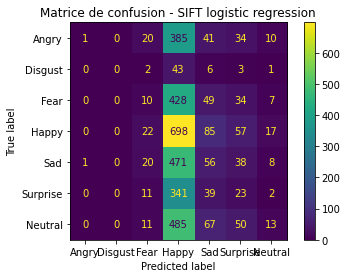

Training accuracy: 
44.91971158870041%
Training error: 
55.08028841129959%
Validation accuracy: 
35.775982167734746%
Validation error: 
64.22401783226526%
Test accuracy: 
35.99888548342157%
Test error: 
64.00111451657844%
Average precision: 38.898193079952236%


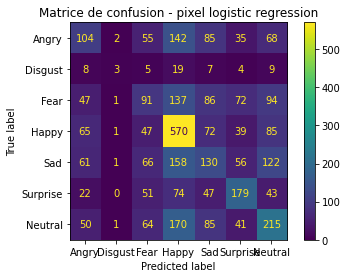

Training accuracy: 
27.343341809188754%
Training error: 
72.65665819081124%
Validation accuracy: 
27.05488994148788%
Validation error: 
72.94511005851211%
Test accuracy: 
27.027027027027028%
Test error: 
72.97297297297297%
Average precision: 27.141752925901226%


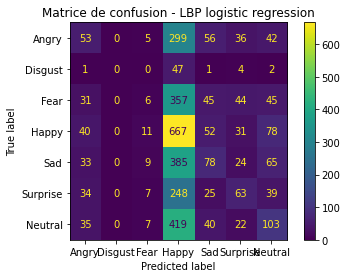

In [13]:
eval_model(sift_lr_classifier, Xtrain_sift, ytrain_sift, Xtest_sift, ytest_sift, Xval_sift, yval_sift, 'SIFT logistic regression')
eval_model(pixel_lr_classifier, Xtrain_flatten, ytrain, Xtest_flatten, ytest, Xval_flatten, yval, 'pixel logistic regression')
eval_model(lbp_lr_classifier, Xtrain_lbp, ytrain, Xtest_lbp, ytest, Xval_lbp, yval, 'LBP logistic regression')

####  Résultats et réponses:


| Algorithme                    | Paramètres    | Precision | %Erreur App | %Erreur Val | %Erreur Tst | 
|-------------------------------|---------------|-----------|-------------|-------------|-------------|
| Regression logistique - SIFT  | C=10:L2       |   23.79%  |   74.47%    |   76.48%    |   77.68%    |
| Regression logistique - Pixel | C=0.01:L1     |   38.90%  |   55.08%    |   64.22%    |   64.00%    |
| Regression logistique - LBP   | C=10:l2       |   27.14%  |   72.65%    |   72.95%    |   72.97%    |

Nous avons commencé par entrainer nos modèles de régression logistique avec le "solver" par défaut lbfgs, toutefois aucun de nos modèles ne convergeait à une solution. Nous avons donc décidé d'utiliser SAGA, qui est une variance de la descente du gradient stochastique et performe mieux sur des ensembles de données contenant un grand nombre d'instances. Les modèles sift et lbp ont donc convergé avec ce changement. Cependant le modèle entrainé sur les pixels des images n'est pas arrivé à des paramètres linéaires stables, même après avoir considérablement augmenté le nombre maximum d'itérations. Cela pourrait être dû à la grosseur du vecteur d'entrée qui est de 2304. 

Nous avons aussi choisi d'utiliser un grid search pour optimiser nos modèles avec les hyperparamètres C, qui est l'inverse de la force de régularisation donc plus C est grand moins la régularisation sera importante, et la pénalité ,qui est l'algorithme de régularisation utilisé.

Les modèles de régression logistique ont toutefois été entrainés sur les vecteurs de primitives sift et lbp extraits au laboratoire précédent. Nous avions conclu durant le laboratoire 1 que ces vecteurs de primitive n'étaient pas discriminants, ce qui explique nos résultats qui sont assez similaires au modèle knn utilisé précédemment. Nous pouvons aussi observer , à l'aide des matrices de confusion que la majorité des exemples ont été classifiés comme étant 'Happy', qui est la classe avec le plus d'instances. Ces résultats des modèles sift, lbp et pixel peuvent aussi être expliqués par une absence de corrélation linéaire entre les valeurs d'entrées et les étiquettes.

### 2c: Créer et évaluer des modèles de classification (Réseaux perceptron multi-couche)

##### À faire:

1. Utiliser [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/classification) pour construire un réseau de neurones multicouche pour classifier les vecteurs de primitives du laboratoire 1. 
2. Choisir l’architecture appropriée pour chaque vecteur de primitives (nombre et dimension des couches). 
2. Entraîner et optimiser les paramètres des réseaux.
4. Faire une analyse des résultats et présenter vos conclusions sur les réseaux de neurones.

#### Code

In [4]:
# Convert labels to one hot encoder
ytrain_ohe = to_categorical(ytrain, len(labels))
yval_ohe = to_categorical(yval, len(labels))
ytest_ohe = to_categorical(ytest, len(labels))

In [6]:
# "SIFT"
sift_input_shape = Xtrain_sift[0].shape

# Create the model
sift_mlp_classifier = Sequential()
sift_mlp_classifier.add(Dense(16, input_shape=sift_input_shape, activation='relu'))
sift_mlp_classifier.add(Dense(len(labels), activation='softmax'))

# Training
sift_mlp_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
sift_mlp_classifier.fit(Xtrain_sift, ytrain_ohe, epochs=30, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/30
180/180 [==============================] - 1s 3ms/step - loss: 1.9023 - accuracy: 0.1958 - val_loss: 1.8421 - val_accuracy: 0.2517
Epoch 2/30
180/180 [==============================] - 1s 3ms/step - loss: 1.8241 - accuracy: 0.2512 - val_loss: 1.8134 - val_accuracy: 0.2517
Epoch 3/30
180/180 [==============================] - 1s 3ms/step - loss: 1.8098 - accuracy: 0.2512 - val_loss: 1.8055 - val_accuracy: 0.2517
Epoch 4/30
180/180 [==============================] - 1s 3ms/step - loss: 1.8036 - accuracy: 0.2513 - val_loss: 1.8002 - val_accuracy: 0.2520
Epoch 5/30
180/180 [==============================] - 1s 3ms/step - loss: 1.7990 - accuracy: 0.2513 - val_loss: 1.7979 - val_accuracy: 0.2518
Epoch 6/30
180/180 [==============================] - 0s 3ms/step - loss: 1.7958 - accuracy: 0.2510 - val_loss: 1.7946 - val_accuracy: 0.2513
Epoch 7/30
180/180 [==============================] - 0s 3ms/step - loss: 1.7933 - accuracy: 0.2521 - val_loss: 1.7929 - val_accuracy: 0.2524
Epoch 

In [9]:
# "pixel"
flatten_input_shape = Xtrain_flatten[0].shape

# Create the model
pixel_mlp_classifier = Sequential()
pixel_mlp_classifier.add(Dense(512, input_shape=flatten_input_shape, activation='relu'))
pixel_mlp_classifier.add(Dense(256, activation='relu'))
pixel_mlp_classifier.add(Dense(128, activation='relu'))
pixel_mlp_classifier.add(Dense(64, activation='relu'))
pixel_mlp_classifier.add(Dense(32, activation='relu'))
pixel_mlp_classifier.add(Dense(16, activation='relu'))
pixel_mlp_classifier.add(Dense(len(labels), activation='softmax'))

# Training
pixel_mlp_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pixel_mlp_classifier.fit(Xtrain_flatten, ytrain_ohe, epochs=30, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/30
180/180 [==============================] - 4s 18ms/step - loss: 15.2373 - accuracy: 0.1569 - val_loss: 1.9295 - val_accuracy: 0.1358
Epoch 2/30
180/180 [==============================] - 4s 20ms/step - loss: 1.9137 - accuracy: 0.2339 - val_loss: 1.9000 - val_accuracy: 0.2517
Epoch 3/30
180/180 [==============================] - 3s 19ms/step - loss: 1.8883 - accuracy: 0.2513 - val_loss: 1.8774 - val_accuracy: 0.2517
Epoch 4/30
180/180 [==============================] - 3s 18ms/step - loss: 1.8685 - accuracy: 0.2512 - val_loss: 1.8602 - val_accuracy: 0.2517
Epoch 5/30
180/180 [==============================] - 3s 18ms/step - loss: 1.8537 - accuracy: 0.2512 - val_loss: 1.8474 - val_accuracy: 0.2517
Epoch 6/30
180/180 [==============================] - 3s 18ms/step - loss: 1.8428 - accuracy: 0.2512 - val_loss: 1.8381 - val_accuracy: 0.2517
Epoch 7/30
180/180 [==============================] - 3s 19ms/step - loss: 1.8349 - accuracy: 0.2512 - val_loss: 1.8314 - val_accuracy: 0.251

In [7]:
# "lbp"
input_shape = Xtrain_lbp[0].shape

# Create the model
lbp_mlp_classifier = Sequential()
lbp_mlp_classifier.add(Dense(64, input_shape=input_shape, activation='relu'))
lbp_mlp_classifier.add(Dense(32, activation='relu'))
lbp_mlp_classifier.add(Dense(16, activation='relu'))
lbp_mlp_classifier.add(Dense(len(labels), activation='softmax'))

# Training
lbp_mlp_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lbp_mlp_classifier.fit(Xtrain_lbp, ytrain_ohe, epochs=30, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/30
180/180 [==============================] - 1s 4ms/step - loss: 1.8584 - accuracy: 0.2040 - val_loss: 1.8043 - val_accuracy: 0.2518
Epoch 2/30
180/180 [==============================] - 1s 3ms/step - loss: 1.8059 - accuracy: 0.2519 - val_loss: 1.8007 - val_accuracy: 0.2537
Epoch 3/30
180/180 [==============================] - 1s 3ms/step - loss: 1.8009 - accuracy: 0.2522 - val_loss: 1.7957 - val_accuracy: 0.2577
Epoch 4/30
180/180 [==============================] - 1s 3ms/step - loss: 1.7966 - accuracy: 0.2538 - val_loss: 1.7903 - val_accuracy: 0.2571
Epoch 5/30
180/180 [==============================] - 1s 3ms/step - loss: 1.7931 - accuracy: 0.2551 - val_loss: 1.7874 - val_accuracy: 0.2588
Epoch 6/30
180/180 [==============================] - 1s 3ms/step - loss: 1.7896 - accuracy: 0.2558 - val_loss: 1.7856 - val_accuracy: 0.2593
Epoch 7/30
180/180 [==============================] - 1s 3ms/step - loss: 1.7866 - accuracy: 0.2572 - val_loss: 1.7824 - val_accuracy: 0.2548
Epoch 

898/898 [==============================] - 1s 1ms/step
Training accuracy: 
25.532063116095998%
Training error: 
74.467936883904%
113/113 [==============================] - 0s 1ms/step
Validation accuracy: 
23.82279186402898%
Validation error: 
76.17720813597101%
113/113 [==============================] - 0s 1ms/step
Test accuracy: 
23.711340206185564%
Test error: 
76.28865979381443%
Average precision: 24.355398395436847%


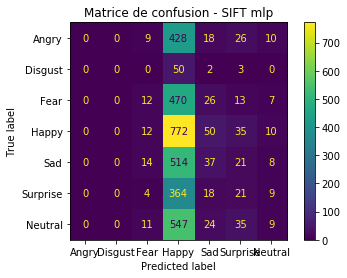

898/898 [==============================] - 4s 4ms/step
Training accuracy: 
25.13149186666202%
Training error: 
74.86850813333798%
113/113 [==============================] - 0s 4ms/step
Validation accuracy: 
24.93730844246308%
Validation error: 
75.06269155753692%
113/113 [==============================] - 0s 4ms/step
Test accuracy: 
24.49150181108944%
Test error: 
75.50849818891056%
Average precision: 24.853434040071512%


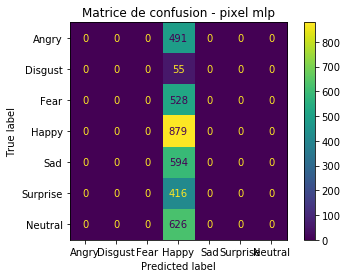

898/898 [==============================] - 1s 1ms/step
Training accuracy: 
26.399386951826955%
Training error: 
73.60061304817305%
113/113 [==============================] - 0s 1ms/step
Validation accuracy: 
26.804123711340207%
Validation error: 
73.1958762886598%
113/113 [==============================] - 0s 1ms/step
Test accuracy: 
26.41404290888827%
Test error: 
73.58595709111174%
Average precision: 26.539184524018474%


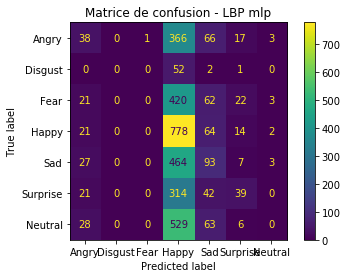

In [10]:
eval_model(sift_mlp_classifier, Xtrain_sift, ytrain, Xtest_sift, ytest, Xval_sift, yval, 'SIFT mlp')
eval_model(pixel_mlp_classifier, Xtrain_flatten, ytrain, Xtest_flatten, ytest, Xval_flatten, yval, 'pixel mlp')
eval_model(lbp_mlp_classifier, Xtrain_lbp, ytrain, Xtest_lbp, ytest, Xval_lbp, yval, 'LBP mlp')

#### Résultats et réponses:
Vos résultats ici

| Algorithme       | Paramètres             | Precision | %Erreur App | %Erreur Val | %Erreur Tst | 
|------------------|------------------------|-----------|-------------|-------------|-------------|
| MLP SIFT         | 16:7                   |   24.36%  |   74.47%    |   76.18%    |   76.29%    |
| MLP Pixel        | 512:256:128:64:32:16:7 |   24.85%  |   74.87%    |   75.06%    |   75.51%    |
| MLP LBP          | 64:32:16:7             |   26.54%  |   73.60%    |   73.20%    |   73.59%    |

Nos réseaux neuronaux sont composés de trois types de couches, la couche d'entrée, les couches cachées et la couche de sortie. Les couches d'entrées pour nos modèles sont basées sur la forme de nos vecteurs d'entrés sift, lbp et le vecteur pixel. Les couches de sortie utilisent la fonction softmax et contiennent 7 neurones, chacun représentant une classe de sortie pour effectuer la classification. Pour ce qui est de nos couches cachées, nous avons utilisé une méthode d'essaie erreur. Nous avons donc essayé plusieurs architectures différentes en ajoutant des couches cachées et en modifiant le nombre de neurones par couche. 

Nous avons aussi décidé d'utiliser ReLU comme fonction d'activation pour sa simplicité, ça rapidité et sa performance générale. Pour le nombre d'epochs, nous sommes allés avec 30 puisque nous avons remarqué que les fonctions de perte ne diminuaient pas considérablement passé ce nombre. De plus, trop d'epochs auraient pu causer un surajustement sur les données d'entrainement et auraient aussi pris plus de temps à effectuer. Pour la batch size nous avons essayé 64, 128, et 256.

Les résultats obtenus sont très semblables à ceux obtenus avec les modèles de régression logistique, c'est à dire, que la majorité des exemples sont classifiés comme étant 'Happy'. Cela ne fait que confirmer ce que nous savions déjà, nos vecteurs de primitives ne sont pas discriminatifs. Toutefois, le modèle étant entrainé sur les pixels a classifié tous les exemples comme étant 'Happy', ce qui indique que le débalancement des classes a un plus gros impact sur nos réseaux de neurones que sur les modèles de régression logistique.  De plus, le taux de classification de 100% de la classe 'Happy' peut être dû à un nombre de couches et des neurones trop élevés. En effet, puisque nous nous sommes seulement basés sur les pourcentages de précision corrects nos modèles sont arrivés à la conclusion que classifier un exemple en tant que 'Happy' avait plus de chance d'être correct que toutes autres classes, dû au nombre d'instances plus élevé de cette classe.

# Partie 3: Explorez l'apprentissage de la représentation et les réseaux neuronaux profonds
## (FER dataset et FG-NET dataset)


##### À faire :
1. Utiliser [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/classification) pour construire un réseau de neurones convolutif pour apprendre une représentation directement des images de visage aussi que les discriminantes. 
2. Choisir l’architecture appropriée : nombre de couches convolutifs (CL), dimension des filtres, “stride”, nombre de couches entièrement connectées (FC) et la dimension des couches). 
3. Entraîner et optimiser les paramètres du réseau.
4. Évaluer la pertinence d’utiliser "data augmentation" pour améliorer la généralisation.
5. Récupérer une des architectures CNN pré-entraînes disponibles dans Keras pour faire une “transfert de connaissance (transfer learning). Faire un "fine-tuning" du modèle choisi sur FER.    
7. Choisir le modèle qu’a donné de meilleurs résultats sur FER et adapter ce modèle pour faire la régression sur FG-NET.     
8. Faire une analyse des résultats et présenter vos conclusions sur les réseaux de neurones.

### 3a: Code CNN (FER)
    
##### À faire:
1. Utiliser [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/classification) pour construire un réseau de neurones convolutif pour apprendre une représentation directement des images de visage aussi que les discriminantes. 
2. Choisir l’architecture appropriée: nombre de couches convolutifs (CL), dimension des filtres, "stride”, nombre de couches entièrement connectées (FC) et la dimension des couches). 
3. Entraîner et optimiser les paramètres du réseau.
4. Évaluer la pertinence d’utiliser "data augmentation" pour améliorer la généralisation.

In [7]:
# Lecture features pixel, SIFT et LBP
(Xtrain, ytrain, Xtest, ytest, Xval, yval) = read_FER_csv('Datasets/fer2013.csv', 2304)

Xtrain = Xtrain.reshape( Xtrain.shape[0], 48, 48, 1 ).astype('uint8')
Xtest  = Xtest.reshape( Xtest.shape[0], 48, 48, 1 ).astype('uint8')
Xval   = Xval.reshape( Xval.shape[0], 48, 48, 1 ).astype('uint8')

ytrain_ohe = to_categorical(ytrain, len(labels))
yval_ohe = to_categorical(yval, len(labels))
ytest_ohe = to_categorical(ytest, len(labels))

In [8]:
#Architecture adaptée à partir de LE: https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342

pixel_cnn = create_my_cnn(Xtrain[0].shape, ytrain_ohe[0].shape[0], 'softmax')

pixel_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pixel_cnn.fit(Xtrain, ytrain_ohe, epochs=30, batch_size=128, verbose=1, validation_data=(Xval, yval_ohe))
pixel_cnn.save('Models/pixel_cnn')

Epoch 1/30
225/225 [==============================] - 13s 54ms/step - loss: 2.9875 - accuracy: 0.2215 - val_loss: 1.7781 - val_accuracy: 0.2575
Epoch 2/30
225/225 [==============================] - 12s 52ms/step - loss: 1.7684 - accuracy: 0.2618 - val_loss: 1.6946 - val_accuracy: 0.3243
Epoch 3/30
225/225 [==============================] - 12s 53ms/step - loss: 1.6927 - accuracy: 0.3044 - val_loss: 1.5999 - val_accuracy: 0.3636
Epoch 4/30
225/225 [==============================] - 12s 53ms/step - loss: 1.6337 - accuracy: 0.3430 - val_loss: 1.5652 - val_accuracy: 0.3865
Epoch 5/30
225/225 [==============================] - 12s 53ms/step - loss: 1.5901 - accuracy: 0.3645 - val_loss: 1.5108 - val_accuracy: 0.4143
Epoch 6/30
225/225 [==============================] - 13s 57ms/step - loss: 1.5494 - accuracy: 0.3856 - val_loss: 1.5054 - val_accuracy: 0.4210
Epoch 7/30
225/225 [==============================] - 13s 56ms/step - loss: 1.5129 - accuracy: 0.4052 - val_loss: 1.4612 - val_accuracy:

INFO:tensorflow:Assets written to: Models/pixel_cnn\assets


INFO:tensorflow:Assets written to: Models/pixel_cnn\assets


Epoch 1/30
225/225 [==============================] - 1s 5ms/step - loss: 3.5697 - accuracy: 0.2423 - val_loss: 1.7132 - val_accuracy: 0.3207
Epoch 2/30
225/225 [==============================] - 1s 5ms/step - loss: 1.7239 - accuracy: 0.3080 - val_loss: 1.6475 - val_accuracy: 0.3541
Epoch 3/30
225/225 [==============================] - 1s 5ms/step - loss: 1.6605 - accuracy: 0.3432 - val_loss: 1.5860 - val_accuracy: 0.3859
Epoch 4/30
225/225 [==============================] - 1s 5ms/step - loss: 1.6007 - accuracy: 0.3756 - val_loss: 1.5301 - val_accuracy: 0.4021
Epoch 5/30
225/225 [==============================] - 1s 5ms/step - loss: 1.5471 - accuracy: 0.3995 - val_loss: 1.5059 - val_accuracy: 0.4174
Epoch 6/30
225/225 [==============================] - 1s 5ms/step - loss: 1.4957 - accuracy: 0.4234 - val_loss: 1.4635 - val_accuracy: 0.4333
Epoch 7/30
225/225 [==============================] - 1s 5ms/step - loss: 1.4378 - accuracy: 0.4491 - val_loss: 1.4467 - val_accuracy: 0.4400
Epoch 

INFO:tensorflow:Assets written to: Models/pixel_cnn_augment/assets


INFO:tensorflow:Assets written to: Models/pixel_cnn_augment/assets


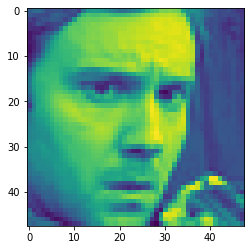

In [5]:
pixel_cnn_augment = create_my_cnn(Xtrain[0].shape, ytrain_ohe[0].shape[0], 'softmax')
Xtrain_augment = augment_data(Xtrain, ytrain_ohe, (48, 48))

pixel_cnn_augment.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pixel_cnn_augment.fit(Xtrain_augment, ytrain_ohe, epochs=30, batch_size=128, verbose=1, validation_data=(Xval, yval_ohe))
pixel_cnn_augment.save('Models/pixel_cnn_augment')

In [6]:
pixel_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        416       
                                                                 
 average_pooling2d (AverageP  (None, 24, 24, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 12, 12, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 120)               5

898/898 [==============================] - 1s 924us/step
<class 'numpy.ndarray'>
Training accuracy: 
83.77512278379602%
Training error: 
16.224877216203982%
113/113 [==============================] - 0s 938us/step
Validation accuracy: 
49.90247979938702%
Validation error: 
50.097520200612976%
113/113 [==============================] - 0s 997us/step
Test accuracy: 
49.31735859570911%
Test error: 
50.682641404290884%
Average precision: 60.998320392964054%


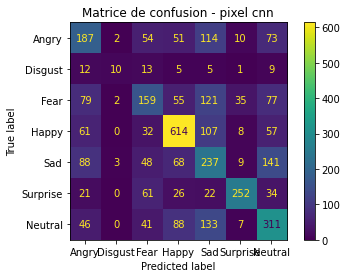

898/898 [==============================] - 1s 916us/step
<class 'numpy.ndarray'>
Training accuracy: 
92.58420704308753%
Training error: 
7.415792956912471%
113/113 [==============================] - 0s 984us/step
Validation accuracy: 
47.199777096684315%
Validation error: 
52.800222903315685%
113/113 [==============================] - 0s 952us/step
Test accuracy: 
48.11925327389245%
Test error: 
51.88074672610755%
Average precision: 62.63441247122144%


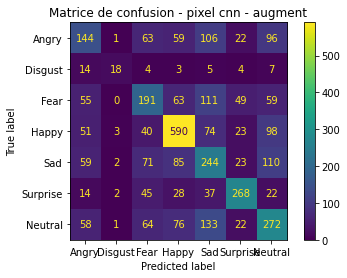

In [6]:
eval_model(pixel_cnn, Xtrain, ytrain, Xtest, ytest, Xval, yval, 'pixel cnn')
eval_model(pixel_cnn_augment, Xtrain, ytrain, Xtest, ytest, Xval, yval, 'pixel cnn - augment')

#### Résultats et réponses:
Vos résultats ici

| Ensemble | My CNN   | My CNN - Augmentation   |
|----------|----------|-------------------------|
| App      | 83.78%   |                  92.58% |
| Val      | 49.90%   |                  47.20% |
| Test     | 50.10%   |                  48.12% |
| Moyenne  | 61.00%   |                  62.63% |

Nous avons basé l'architecture de notre CNN sur LE net 5. Pour accélérer l'entraînement nous avons remplacé la troisième couche de convolution par une couche de neurones. De plus, nous avons utilisé la fonction d'activation RELU plutôt que tanh.

Nous avons ensuite fait quelques tests d'entraînement. Dans ces tests, nous avons trouvé que 30 epochs était suffisant pour faire converger le modèle sans causer de surentraînement.

Durant ses tests d'entraînement initiaux. Nous avons alors remarqué que le modèle convergeait très rapidement pour l'ensemble d'entraînement. En effet, au bout de quelques epochs, la précision dépassait 90%. Cependant, la performance pour l'ensemble de validation était de moins de 40%. Pour régler ce problème, nous avons ajouté des couches de Dropout pour éviter le surentraînement. Cette modification nous a permis d'atteindre une précision d'approximativement 50% pour les ensembles de test et de validation.

Par la suite, nous avons tenté d'appliquer l'augmentation de données pour rendre le modèle plus généralisable. Nous avons utilisé Keras pour appliqué les transformations suivantes:
- Inversion aléatoire verticale et horizontale de l'image
- Rotation aléatoire
- Changement aléatoire du contraste et de la luminosité
- Étirement vertical et horizontal aléatoire

Contre-intuitivement, nous avons observé une meilleure performance pour l'ensemble d'entraînement et une moins bonne performance les ensembles de validation et de test que pour l'entraînement sans augmentation. Nous avons donc conclut que, pour notre CNN, l'augmentation de données n'est pas pertinent.

### 3b: Code CNN Pré-entraîné (FER)

##### À faire:
1. Récupérer une des architectures [CNN pré-entraînes disponibles dans Keras](https://keras.io/api/applications/) pour faire un "transfert de connaissance" (transfer learning). Faire un "fine-tuning" du modèle choisi sur FER.    
2. Entraîner et optimiser les paramètres du réseau.
3. Évaluer la pertinence d’utiliser "data augmentation" pour améliorer la généralisation.

##### Sans augmentation:

In [5]:
Xtrain_rgb, Xval_rgb, Xtest_rgb = convert_to_rgb(Xtrain, Xval, Xtest, 48, 48)

In [102]:

pretrained_resnet50 = ResNet50(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

resnet50 = transfer_train(pretrained_resnet50, Xtrain_rgb, ytrain_ohe, Xval_rgb, yval_ohe)
resnet50.save("Models/resnet50")

Epoch 1/30
225/225 [==============================] - ETA: 0s - loss: 1.6520 - accuracy: 0.3743

2022-07-04 15:29:50.950276: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-04 15:29:50.950319: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-04 15:29:50.964561: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-04 15:29:50.964587: W tensorflow/core/common_runtime/bfc_allocato

225/225 [==============================] - 9s 30ms/step - loss: 1.6520 - accuracy: 0.3743 - val_loss: 1.5402 - val_accuracy: 0.4037
Epoch 2/30
225/225 [==============================] - 6s 26ms/step - loss: 1.4817 - accuracy: 0.4305 - val_loss: 1.4965 - val_accuracy: 0.4205
Epoch 3/30
225/225 [==============================] - 6s 25ms/step - loss: 1.4114 - accuracy: 0.4607 - val_loss: 1.4814 - val_accuracy: 0.4335
Epoch 4/30
225/225 [==============================] - 6s 25ms/step - loss: 1.3558 - accuracy: 0.4854 - val_loss: 1.4574 - val_accuracy: 0.4436
Epoch 5/30
225/225 [==============================] - 6s 26ms/step - loss: 1.3056 - accuracy: 0.5088 - val_loss: 1.4627 - val_accuracy: 0.4436
Epoch 6/30
225/225 [==============================] - 6s 26ms/step - loss: 1.2558 - accuracy: 0.5278 - val_loss: 1.4587 - val_accuracy: 0.4525
Epoch 7/30
225/225 [==============================] - 6s 26ms/step - loss: 1.2125 - accuracy: 0.5454 - val_loss: 1.4843 - val_accuracy: 0.4519
Epoch 8/30

INFO:tensorflow:Assets written to: Models/resnet50/assets


INFO:tensorflow:Assets written to: Models/resnet50/assets


In [103]:
pretrained_mobilenet = MobileNetV2(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

mobilenet = transfer_train(pretrained_mobilenet, Xtrain_rgb, ytrain_ohe, Xval_rgb, yval_ohe)
mobilenet.save("Models/mobilenet")

Epoch 1/30
225/225 [==============================] - 6s 18ms/step - loss: 1.8030 - accuracy: 0.2626 - val_loss: 1.7505 - val_accuracy: 0.2867
Epoch 2/30
225/225 [==============================] - 3s 14ms/step - loss: 1.7156 - accuracy: 0.3032 - val_loss: 1.7364 - val_accuracy: 0.2948
Epoch 3/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6898 - accuracy: 0.3190 - val_loss: 1.7359 - val_accuracy: 0.2926
Epoch 4/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6671 - accuracy: 0.3284 - val_loss: 1.7193 - val_accuracy: 0.3051
Epoch 5/30
225/225 [==============================] - 3s 15ms/step - loss: 1.6522 - accuracy: 0.3403 - val_loss: 1.7265 - val_accuracy: 0.2895
Epoch 6/30
225/225 [==============================] - 3s 15ms/step - loss: 1.6364 - accuracy: 0.3457 - val_loss: 1.7203 - val_accuracy: 0.3012
Epoch 7/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6206 - accuracy: 0.3559 - val_loss: 1.7142 - val_accuracy: 0.3090

INFO:tensorflow:Assets written to: Models/mobilenet/assets


INFO:tensorflow:Assets written to: Models/mobilenet/assets


In [104]:
pretrained_vgg19 = VGG19(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

vgg19 = transfer_train(pretrained_vgg19, Xtrain_rgb, ytrain_ohe, Xval_rgb, yval_ohe)
vgg19.save('Models/vgg19')

Epoch 1/30
225/225 [==============================] - 9s 37ms/step - loss: 5.4351 - accuracy: 0.2818 - val_loss: 2.8940 - val_accuracy: 0.3215
Epoch 2/30
225/225 [==============================] - 8s 34ms/step - loss: 2.3393 - accuracy: 0.3482 - val_loss: 2.2685 - val_accuracy: 0.3458
Epoch 3/30
225/225 [==============================] - 8s 34ms/step - loss: 1.8228 - accuracy: 0.3842 - val_loss: 1.9062 - val_accuracy: 0.3711
Epoch 4/30
225/225 [==============================] - 8s 34ms/step - loss: 1.6115 - accuracy: 0.4184 - val_loss: 1.7977 - val_accuracy: 0.3728
Epoch 5/30
225/225 [==============================] - 8s 34ms/step - loss: 1.4996 - accuracy: 0.4471 - val_loss: 1.7746 - val_accuracy: 0.3926
Epoch 6/30
225/225 [==============================] - 8s 34ms/step - loss: 1.4342 - accuracy: 0.4637 - val_loss: 1.7441 - val_accuracy: 0.3709
Epoch 7/30
225/225 [==============================] - 8s 34ms/step - loss: 1.3743 - accuracy: 0.4835 - val_loss: 1.7312 - val_accuracy: 0.3842

INFO:tensorflow:Assets written to: Models/vgg19/assets


INFO:tensorflow:Assets written to: Models/vgg19/assets


In [105]:
pretrained_EfficientNetV2L= EfficientNetV2L(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

efficientNetV2L = transfer_train(pretrained_vgg19, Xtrain_rgb, ytrain_ohe, Xval_rgb, yval_ohe)
efficientNetV2L.save('Models/efficientNet')

Epoch 1/30
225/225 [==============================] - 8s 35ms/step - loss: 5.0372 - accuracy: 0.2759 - val_loss: 2.7334 - val_accuracy: 0.2984
Epoch 2/30
225/225 [==============================] - 8s 35ms/step - loss: 2.1725 - accuracy: 0.3369 - val_loss: 1.9640 - val_accuracy: 0.3458
Epoch 3/30
225/225 [==============================] - 8s 35ms/step - loss: 1.7132 - accuracy: 0.3855 - val_loss: 1.8215 - val_accuracy: 0.3477
Epoch 4/30
225/225 [==============================] - 8s 35ms/step - loss: 1.5548 - accuracy: 0.4190 - val_loss: 1.6909 - val_accuracy: 0.3728
Epoch 5/30
225/225 [==============================] - 8s 35ms/step - loss: 1.4632 - accuracy: 0.4485 - val_loss: 1.6725 - val_accuracy: 0.3892
Epoch 6/30
225/225 [==============================] - 8s 35ms/step - loss: 1.4095 - accuracy: 0.4641 - val_loss: 1.6554 - val_accuracy: 0.3929
Epoch 7/30
225/225 [==============================] - 8s 35ms/step - loss: 1.3678 - accuracy: 0.4816 - val_loss: 1.6490 - val_accuracy: 0.3965

INFO:tensorflow:Assets written to: Models/efficientNet/assets


INFO:tensorflow:Assets written to: Models/efficientNet/assets


##### Augmentation:

In [12]:
Xtrain_rgb_augment = augment_data(Xtrain_rgb, ytrain_ohe, (48, 48))

2022-07-04 15:59:39.061469: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1587492864 exceeds 10% of free system memory.
2022-07-04 15:59:39.713533: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1587492864 exceeds 10% of free system memory.


In [13]:
pretrained_resnet50 = ResNet50(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

resnet50 = transfer_train(pretrained_resnet50, Xtrain_rgb_augment, ytrain_ohe, Xval_rgb, yval_ohe)
resnet50.save("Models/resnet50_augment")

Epoch 1/30


2022-07-04 15:59:50.049053: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


225/225 [==============================] - 10s 30ms/step - loss: 1.6354 - accuracy: 0.3769 - val_loss: 1.5242 - val_accuracy: 0.4037
Epoch 2/30
225/225 [==============================] - 6s 25ms/step - loss: 1.4766 - accuracy: 0.4352 - val_loss: 1.5119 - val_accuracy: 0.4168
Epoch 3/30
225/225 [==============================] - 6s 25ms/step - loss: 1.4122 - accuracy: 0.4628 - val_loss: 1.4839 - val_accuracy: 0.4344
Epoch 4/30
225/225 [==============================] - 6s 26ms/step - loss: 1.3614 - accuracy: 0.4805 - val_loss: 1.4542 - val_accuracy: 0.4397
Epoch 5/30
225/225 [==============================] - 6s 25ms/step - loss: 1.3169 - accuracy: 0.5021 - val_loss: 1.4791 - val_accuracy: 0.4377
Epoch 6/30
225/225 [==============================] - 6s 25ms/step - loss: 1.2686 - accuracy: 0.5205 - val_loss: 1.4571 - val_accuracy: 0.4592
Epoch 7/30
225/225 [==============================] - 6s 25ms/step - loss: 1.2232 - accuracy: 0.5397 - val_loss: 1.4592 - val_accuracy: 0.4539
Epoch 8/3

INFO:tensorflow:Assets written to: Models/resnet50_augment/assets


INFO:tensorflow:Assets written to: Models/resnet50_augment/assets


In [14]:
pretrained_mobilenet = MobileNetV2(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

mobilenet = transfer_train(pretrained_mobilenet, Xtrain_rgb_augment, ytrain_ohe, Xval_rgb, yval_ohe)
mobilenet.save("Models/mobilenet_augment")

Epoch 1/30
225/225 [==============================] - 6s 19ms/step - loss: 1.7950 - accuracy: 0.2676 - val_loss: 1.7637 - val_accuracy: 0.2731
Epoch 2/30
225/225 [==============================] - 3s 14ms/step - loss: 1.7208 - accuracy: 0.2993 - val_loss: 1.7394 - val_accuracy: 0.2967
Epoch 3/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6962 - accuracy: 0.3142 - val_loss: 1.7481 - val_accuracy: 0.2906
Epoch 4/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6701 - accuracy: 0.3318 - val_loss: 1.7206 - val_accuracy: 0.3098
Epoch 5/30
225/225 [==============================] - 4s 16ms/step - loss: 1.6569 - accuracy: 0.3374 - val_loss: 1.7127 - val_accuracy: 0.3040
Epoch 6/30
225/225 [==============================] - 3s 15ms/step - loss: 1.6397 - accuracy: 0.3456 - val_loss: 1.7217 - val_accuracy: 0.3076
Epoch 7/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6282 - accuracy: 0.3493 - val_loss: 1.7191 - val_accuracy: 0.3118

INFO:tensorflow:Assets written to: Models/mobilenet_augment/assets


INFO:tensorflow:Assets written to: Models/mobilenet_augment/assets


In [15]:
pretrained_vgg19 = VGG19(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

vgg19 = transfer_train(pretrained_vgg19, Xtrain_rgb_augment, ytrain_ohe, Xval_rgb, yval_ohe)
vgg19.save('Models/vgg19_augment')

Epoch 1/30
225/225 [==============================] - 10s 37ms/step - loss: 4.5895 - accuracy: 0.2850 - val_loss: 2.4050 - val_accuracy: 0.3132
Epoch 2/30
225/225 [==============================] - 8s 34ms/step - loss: 1.9717 - accuracy: 0.3329 - val_loss: 1.8411 - val_accuracy: 0.3344
Epoch 3/30
225/225 [==============================] - 8s 34ms/step - loss: 1.6660 - accuracy: 0.3786 - val_loss: 1.7102 - val_accuracy: 0.3628
Epoch 4/30
225/225 [==============================] - 8s 35ms/step - loss: 1.5441 - accuracy: 0.4148 - val_loss: 1.6619 - val_accuracy: 0.3798
Epoch 5/30
225/225 [==============================] - 8s 34ms/step - loss: 1.4775 - accuracy: 0.4341 - val_loss: 1.6334 - val_accuracy: 0.3873
Epoch 6/30
225/225 [==============================] - 8s 35ms/step - loss: 1.4221 - accuracy: 0.4565 - val_loss: 1.6266 - val_accuracy: 0.3926
Epoch 7/30
225/225 [==============================] - 8s 35ms/step - loss: 1.3814 - accuracy: 0.4738 - val_loss: 1.6493 - val_accuracy: 0.402

INFO:tensorflow:Assets written to: Models/vgg19_augment/assets


INFO:tensorflow:Assets written to: Models/vgg19_augment/assets


In [16]:
pretrained_EfficientNetV2L= EfficientNetV2L(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

efficientNetV2L = transfer_train(pretrained_vgg19, Xtrain_rgb_augment, ytrain_ohe, Xval_rgb, yval_ohe)
efficientNetV2L.save('Models/efficientNet_augment')

Epoch 1/30
225/225 [==============================] - 9s 37ms/step - loss: 4.4709 - accuracy: 0.2754 - val_loss: 2.2667 - val_accuracy: 0.3015
Epoch 2/30
225/225 [==============================] - 8s 36ms/step - loss: 1.8805 - accuracy: 0.3361 - val_loss: 1.7668 - val_accuracy: 0.3380
Epoch 3/30
225/225 [==============================] - 8s 36ms/step - loss: 1.6225 - accuracy: 0.3793 - val_loss: 1.6801 - val_accuracy: 0.3625
Epoch 4/30
225/225 [==============================] - 8s 36ms/step - loss: 1.5261 - accuracy: 0.4134 - val_loss: 1.6622 - val_accuracy: 0.3789
Epoch 5/30
225/225 [==============================] - 8s 36ms/step - loss: 1.4654 - accuracy: 0.4366 - val_loss: 1.6278 - val_accuracy: 0.3884
Epoch 6/30
225/225 [==============================] - 8s 36ms/step - loss: 1.4205 - accuracy: 0.4534 - val_loss: 1.6326 - val_accuracy: 0.3870
Epoch 7/30
225/225 [==============================] - 8s 36ms/step - loss: 1.3830 - accuracy: 0.4725 - val_loss: 1.6453 - val_accuracy: 0.3901

INFO:tensorflow:Assets written to: Models/efficientNet_augment/assets


INFO:tensorflow:Assets written to: Models/efficientNet_augment/assets


#### Résultats et réponses:

898/898 [==============================] - 11s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
86.47810791041137%
Training error: 
13.521892089588627%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
44.608526051825024%
Validation error: 
55.39147394817498%
113/113 [==============================] - 1s 10ms/step
Test accuracy: 
45.416550571189745%
Test error: 
54.58344942881026%
Average precision: 58.834394844475376%


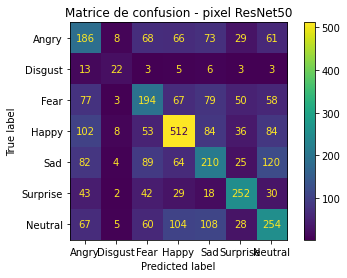

898/898 [==============================] - 7s 7ms/step
<class 'numpy.ndarray'>
Training accuracy: 
53.16102964227246%
Training error: 
46.83897035772754%
113/113 [==============================] - 1s 6ms/step
Validation accuracy: 
31.262190025076624%
Validation error: 
68.73780997492338%
113/113 [==============================] - 1s 6ms/step
Test accuracy: 
30.927835051546392%
Test error: 
69.0721649484536%
Average precision: 38.45035157296516%


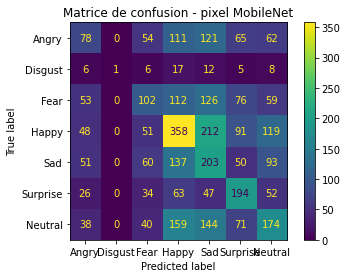

898/898 [==============================] - 10s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
69.10724859800062%
Training error: 
30.892751401999373%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
40.06687099470604%
Validation error: 
59.93312900529395%
113/113 [==============================] - 1s 11ms/step
Test accuracy: 
42.57453329618278%
Test error: 
57.42546670381722%
Average precision: 50.582884296296484%


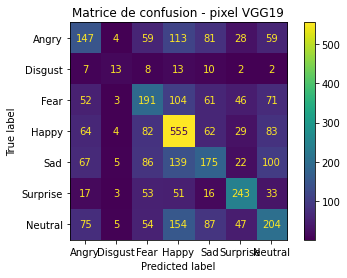

898/898 [==============================] - 10s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
68.8564561635724%
Training error: 
31.1435438364276%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
38.86876567288938%
Validation error: 
61.13123432711062%
113/113 [==============================] - 1s 11ms/step
Test accuracy: 
41.543605461131236%
Test error: 
58.45639453886877%
Average precision: 49.75627576586434%


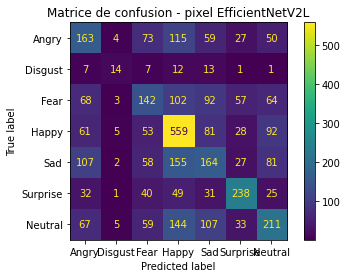

In [17]:
resnet50 = keras.models.load_model("Models/resnet50")
mobilenet = keras.models.load_model("Models/mobilenet")
vgg19 = keras.models.load_model('Models/vgg19')
efficientNetV2L = keras.models.load_model('Models/efficientNet')

eval_model(resnet50, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel ResNet50')
eval_model(mobilenet, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel MobileNet')
eval_model(vgg19, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel VGG19')
eval_model(efficientNetV2L, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel EfficientNetV2L')

2022-07-04 16:29:55.834405: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


898/898 [==============================] - 12s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
84.61806402173534%
Training error: 
15.38193597826466%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
44.71997770966843%
Validation error: 
55.28002229033157%
113/113 [==============================] - 1s 11ms/step
Test accuracy: 
44.9707439398161%
Test error: 
55.0292560601839%
Average precision: 58.1029285570733%


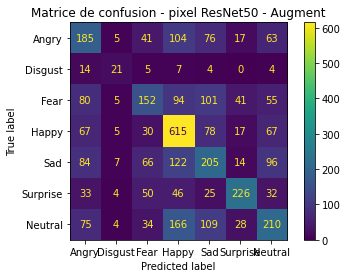

898/898 [==============================] - 7s 7ms/step
<class 'numpy.ndarray'>
Training accuracy: 
51.31143543836427%
Training error: 
48.68856456163573%
113/113 [==============================] - 1s 6ms/step
Validation accuracy: 
31.707996656450266%
Validation error: 
68.29200334354974%
113/113 [==============================] - 1s 6ms/step
Test accuracy: 
30.760657564781273%
Test error: 
69.23934243521872%
Average precision: 37.9266965531986%


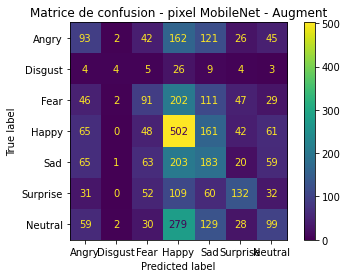

898/898 [==============================] - 10s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
68.28172350134103%
Training error: 
31.71827649865896%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
40.26191139593202%
Validation error: 
59.73808860406798%
113/113 [==============================] - 1s 11ms/step
Test accuracy: 
40.65199219838395%
Test error: 
59.34800780161604%
Average precision: 49.73187569855234%


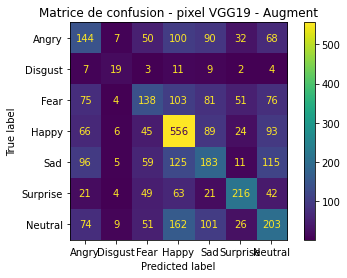

898/898 [==============================] - 10s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
67.56766170887178%
Training error: 
32.43233829112822%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
40.401225968236275%
Validation error: 
59.598774031763725%
113/113 [==============================] - 1s 11ms/step
Test accuracy: 
40.568403455001395%
Test error: 
59.43159654499861%
Average precision: 49.51243037736982%


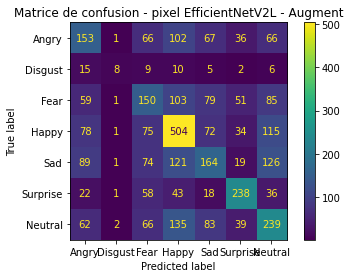

In [6]:
resnet50_augment = keras.models.load_model("Models/resnet50_augment")
mobilenet_augment = keras.models.load_model("Models/mobilenet_augment")
vgg19_augment = keras.models.load_model('Models/vgg19_augment')
efficientNetV2L_augment = keras.models.load_model('Models/efficientNet_augment')

eval_model(resnet50_augment, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel ResNet50 - Augment')
eval_model(mobilenet_augment, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel MobileNet - Augment')
eval_model(vgg19_augment, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel VGG19 - Augment')
eval_model(efficientNetV2L_augment, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel EfficientNetV2L - Augment')

#### Sans Augmentation
| Ensemble | My CNN   | Resnet50   | MobileNetV2 | VGG 19 | EfficientNetV2L |
|----------|----------|------------|-------------|--------|-----------------|
| App      | 83.78%   |     80.32% |    47.29%   | 62.84% |          65.58% |
| Val      | 49.90%   |     43.69% |    30.29%   | 37.16% |          39.45% |
| Test     | 50.10%   |     45.33% |    29.73%   | 39.12% |          39.98% |
| Moyenne  | 61.00%   |     56.45% |    35.77%   | 47.06% |          48.34% |

#### Augmentation
| Ensemble | My CNN   | Resnet50   | MobileNetV2 | VGG 19 | EfficientNetV2L |
|----------|----------|------------|-------------|--------|-----------------|
| App      | 92.58%   |     84.62% |    51.31%   | 68.28% |          67.57% |
| Val      | 47.20%   |     44.72% |    31.71%   | 40.26% |          40.40% |
| Test     | 48.12%   |     44.97% |    30.76%   | 40.65% |          40.57% |
| Moyenne  | 62.63%   |     58.10% |    37.93%   | 49.73% |          49.51% |


Pour s'assurer d'avoir la meilleur performance possible, nous avons évalué un maximum de modèles pré-entraînés sur nos ensembles de données. Pour tous les modèles, nous avons pris le modèles pré-entraîné sans la couche de sortie. Ces couches étaient figées lors de notre entraînement. Nous avons ensuite ajouté une couche dense intermédiaire non-figée de 100 neurones et une couche dense de sortie avec 7 neurones pour nos 7 classes.

De plus, il a été nécessaire d'adapter nos images pour qu'elles aient 3 canaux puisque les modèles pré-entraînés utilisés ont été entraînés sur des images en couleur RGB. Pour ce faire, nous avons utilisé la fonction cvtColor de opencv pour convertir les images du format noir et blanc à RGB.

Nous avons aussi décidé de ne pas altérer la résolution des images pour le transfert de connaissance pour réduire le nombre de variables à contrôler pour l'entraînement. Tous les modèles ont donc été entraînés avec les images en format 48x48. Cela a causé un avertissement lors de l'entraînement de MobileNetV2, ce qui pourrait avoir affecté l'efficacité du transfert de connaissance.

Pour l'entraînement et l'évaluation, nous avons utilisé un protocole identique pour tous les modèles. C'est à dire que nous avons entraîné chaque modèle sur l'ensemble d'entraînement de FER pour 30 epochs. Par la suite nous avons testé le modèle en calculant la précision de prédiction sur l'ensemble d'entraînement, de test et de validation de FER.

Notre évaluation du transfert de connaissance a révélé que, parmi les modèles pré-entraînés sélectionné, Resnet50 a la meilleur performance sur nos modèle avec une performance de 43.69% et 45.33% sur notre ensemble de validation et de test respectivement. Pour MobileNetV2, VGG 19 et EfficientNetV2L, nous avons aussi remarqué que l'augmentation des données a eu un effet positif (mais relativement petit) sur la performance de ceux-ci pour l'ensemble de validation et de test. Cependant, pour Resnet50, les résultats ont été mitigés car le modèle entraîné avec l'augmentation a mieux performé sur les données de validation mais légèrement moins bien sur les données de validation.

Ces essais ont aussi révélé que le CNN que nous avons créé et entraîné à la section 3a a une performance supérieure à celle de tous les modèle pré-entraîné. Nous estimons que c'est le cas car notre CNN est conçu directement pour les images en noir et blanc. Les autres modèles testés ont donc probablement été pénalisés par le fait qu'ils devaient traiter des images en noir et blanc converties vers un format RGB.

Étant donné ces résultats, nous utiliserons notre CNN entraîné sur des données non-augmentées dans la section suivante.

### 3c: Code CNN Pré-entraîné (FG-NET):

##### À faire:
1. Choisir le modèle \ l’architecture qu’a donné de meilleurs résultats sur FER pour faire un “transfert de connaissance (transfer learning).
2. Adapter ce modèle pour FG-NET (couche de sortie classification (7 unités avec softmax) -> régression (1 unité lineaire)).   
3. Entraîner ("fine-tuning" du modèle choisi sur FG-NET) et optimiser les paramètres du réseau pour la régression.
4. Évaluer la pertinence d’utiliser "data augmentation" pour améliorer la généralisation.
5. Faire une analyse des résultats et présenter vos conclusions sur les réseaux de neurones.

In [5]:
X_fgnet = np.loadtxt('Datasets/fgnet_256x256.csv', delimiter=',', dtype=int )
y_fgnet = np.loadtxt('Datasets/fgnet_labels.csv', delimiter=',', dtype=int )

X_fgnet = X_fgnet.reshape(X_fgnet.shape[0], 256, 256, 1)
X_fgnet = pretreat_fgnet(X_fgnet)

#Notre modèle est entraîné sur des valeurs entre 0 et 255. Il faut ajuster les valeurs des pixels
X_fgnet *= 255

Xtrain_fgnet, Xtest_fgnet, ytrain_fgnet, ytest_fgnet = sklearn.model_selection.train_test_split(X_fgnet, y_fgnet, test_size=0.2, random_state=1)
Xtrain_fgnet, Xval_fgnet, ytrain_fgnet, yval_fgnet = sklearn.model_selection.train_test_split(Xtrain_fgnet, ytrain_fgnet, test_size=0.25, random_state=1)

Xtrain_fgnet_augment = augment_data(Xtrain_fgnet, ytrain_fgnet, (48, 48))

In [9]:
# Nos meilleurs résultats ont été observés avec le modèle My CNN sans augmentation
pixel_cnn_fg: Sequential = keras.models.load_model('Models/pixel_cnn')
pixel_cnn_fg.pop()
for layer in pixel_cnn_fg.layers:
      layer.trainable = False
pixel_cnn_fg.add(Dense(1, activation='linear', name='Dense3'))

# Training
pixel_cnn_fg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['MSE'])
pixel_cnn_fg.fit(Xtrain_fgnet, ytrain_fgnet, epochs=60, batch_size=128, verbose=1, validation_split=0.2)
pixel_cnn_fg.save('Models/pixel_cnn_fg')

Epoch 1/60
4/4 [==============================] - 1s 68ms/step - loss: 1.8070e-06 - MSE: 397.2514 - val_loss: 2.0156e-06 - val_MSE: 479.9283
Epoch 2/60
4/4 [==============================] - 0s 28ms/step - loss: 1.8070e-06 - MSE: 395.7862 - val_loss: 2.0156e-06 - val_MSE: 479.9283
Epoch 3/60
4/4 [==============================] - 0s 25ms/step - loss: 1.8070e-06 - MSE: 395.9452 - val_loss: 2.0156e-06 - val_MSE: 479.9283
Epoch 4/60
4/4 [==============================] - 0s 26ms/step - loss: 1.8070e-06 - MSE: 398.7474 - val_loss: 2.0156e-06 - val_MSE: 479.9283
Epoch 5/60
4/4 [==============================] - 0s 25ms/step - loss: 1.8070e-06 - MSE: 397.5428 - val_loss: 2.0156e-06 - val_MSE: 479.9283
Epoch 6/60
4/4 [==============================] - 0s 25ms/step - loss: 1.8070e-06 - MSE: 401.8563 - val_loss: 2.0156e-06 - val_MSE: 479.9283
Epoch 7/60
4/4 [==============================] - 0s 27ms/step - loss: 1.8070e-06 - MSE: 395.1256 - val_loss: 2.0156e-06 - val_MSE: 479.9283
Epoch 8/60
4/

INFO:tensorflow:Assets written to: Models/pixel_cnn_fg\assets


INFO:tensorflow:Assets written to: Models/pixel_cnn_fg\assets


In [10]:
#"pixel"
# Create the model
pixel_cnn_fg_augment: Sequential = keras.models.load_model('Models/pixel_cnn')
pixel_cnn_fg_augment.pop()
for layer in pixel_cnn_fg_augment.layers:
      layer.trainable = False
pixel_cnn_fg_augment.add(Dense(1, activation='linear'))

# Training
pixel_cnn_fg_augment.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['MSE'])
pixel_cnn_fg_augment.fit(Xtrain_fgnet_augment, ytrain_fgnet, epochs=60, batch_size=128, verbose=1, validation_split=0.2)
pixel_cnn_fg_augment.save('Models/pixel_cnn_fg_augment')

Epoch 1/60
4/4 [==============================] - 1s 63ms/step - loss: 1.8070e-06 - MSE: 401.1319 - val_loss: 2.0156e-06 - val_MSE: 485.6025
Epoch 2/60
4/4 [==============================] - 0s 26ms/step - loss: 1.8070e-06 - MSE: 401.1362 - val_loss: 2.0156e-06 - val_MSE: 485.6025
Epoch 3/60
4/4 [==============================] - 0s 27ms/step - loss: 1.8070e-06 - MSE: 399.2314 - val_loss: 2.0156e-06 - val_MSE: 485.6025
Epoch 4/60
4/4 [==============================] - 0s 27ms/step - loss: 1.8070e-06 - MSE: 402.1341 - val_loss: 2.0156e-06 - val_MSE: 485.6025
Epoch 5/60
4/4 [==============================] - 0s 27ms/step - loss: 1.8070e-06 - MSE: 401.0142 - val_loss: 2.0156e-06 - val_MSE: 485.6025
Epoch 6/60
4/4 [==============================] - 0s 25ms/step - loss: 1.8070e-06 - MSE: 399.6349 - val_loss: 2.0156e-06 - val_MSE: 485.6025
Epoch 7/60
4/4 [==============================] - 0s 25ms/step - loss: 1.8070e-06 - MSE: 399.4146 - val_loss: 2.0156e-06 - val_MSE: 485.6025
Epoch 8/60
4/

INFO:tensorflow:Assets written to: Models/pixel_cnn_fg_augment\assets


INFO:tensorflow:Assets written to: Models/pixel_cnn_fg_augment\assets


In [33]:
pixel_cnn_fg = keras.models.load_model("Models/pixel_cnn_fg")

eval_regression_model(pixel_cnn_fg, Xtrain_fgnet, ytrain_fgnet, Xtest_fgnet, ytest_fgnet, Xval_fgnet, yval_fgnet, 'pixel CNN')

7/7 [==============================] - 0s 1ms/step
Training Set
MAE: 15.508333333333333
MSE: 404.5416666666667
R2: -1.4662172603033174
Validation Set
MAE: 16.149253731343283
MSE: 429.2437810945274
R2: -1.548266793155162
Test Set
MAE: 16.52238805970149
MSE: 438.5422885572139
R2: -1.6489543404760343
7/7 [==============================] - 0s 1ms/step
Training Set
MAE: 15.508333333333333
MSE: 404.5416666666667
R2: -1.4662172603033174
Validation Set
MAE: 16.149253731343283
MSE: 429.2437810945274
R2: -1.548266793155162
Test Set
MAE: 16.52238805970149
MSE: 438.5422885572139
R2: -1.6489543404760343


#### Résultats et réponses:

In [ ]:
pixel_cnn_fg_augment = keras.models.load_model("Models/pixel_cnn_fg_augment")
eval_regression_model(pixel_cnn_fg_augment, Xtrain_fgnet, ytrain_fgnet, Xtest_fgnet, ytest_fgnet, Xval_fgnet, yval_fgnet, 'pixel CNN - Augment')

7/7 [==============================] - 0s 1ms/step
Training Set
MAE: 15.508333333333333
MSE: 404.5416666666667
R2: -1.4662172603033174
Validation Set
MAE: 16.149253731343283
MSE: 429.2437810945274
R2: -1.548266793155162
Test Set
MAE: 16.52238805970149
MSE: 438.5422885572139
R2: -1.6489543404760343


##### My CNN - Sans augmentation:
| Ensemble | MAE      | MSE           | R2     |
|----------|----------|---------------|--------|
| App      | 15.51    |     404.54    | -1.47  |
| Val      | 16.15    |     429.24    | -1.55  |
| Test     | 16.52    |     438.54    | -1.65  |

##### My CNN - Avec augmentation:
| Ensemble | MAE      | MSE           | R2     |
|----------|----------|---------------|--------|
| App      | 15.51    |     404.54    | -1.47  |
| Val      | 16.15    |     429.24    | -1.55  |
| Test     | 16.52    |     438.54    | -1.65  |

Pour adapter notre modèle à l'ensemble de données FG-NET, nous avons tout simplement remplacé la couche de sortie de 7 neurones avec activation softmax avec un couche d'une neurone avec activation linéaire. Nous avons ensuite entraîné le modèle avec le même protocole que dans les sections précédentes avec et sans augmentation. Puisqu'il s'agit d'un modèle de régression, nous avons aussi utilisé l'erreur quadratique comme fonction *loss*. Pour l'évaluation du modèle, nous avons calculé l'erreur absolue, l'erreur quadratique et le coefficient de détermination sur les trois ensembles de données de FER.

L'évaluation du modèle entraîné par transfert de connaissance démontre une très mauvaise performance. En effet, les prédictions ont, en moyenne, une erreur de 15 à 16 ans sur les ensembles testés. Le coefficient de détermination a aussi une valeur négative, ce qui indique une très mauvaise corrélation entre les valeurs prédites et la vérité terrain. Nous croyons que ces résultats faibles sont dûs au fait que les caractéristiques extraites pour déterminer l'émotion d'un visage sont très différentes de celles qui devraient être utilisées pour l'estimation de l'âge. En effet, notre CNN est probablement adapté pour extraire des informations liées à la forme de la bouche et des yeux, des caractéristiques discriminantes pour les émotions. Cependant, les expressions faciales n'ont pas de lien avec l'âge d'un individu. Il serait donc meilleur d'entraîner un nouveau modèle pour faire l'estimation d'âge. Ce CNN pourrait apprendre à extraire des caractéristiques comme les rides et détecter les cheveux blancs.

## Partie Final: Conclusion

##### À faire:
1. Résumer et comparer les principaux résultats obtenus pour la classification (FER) et régression (FG-NET).
2. Faire une analyse des résultats obtenus et présenter vos conclusions sur les différents modèles que vous avez entraînés (classification et régression).
3. Comparer les résultats obtenus sur FER avec les résultats du laboratoire 1 (vecteur de pixels, vecteur de primitives). Avez-vous observé une amélioration? Commenter sur les temps d'apprentissage, complexité spatiale et temporelle, etc.

#### Résultats et réponses:
Vos résultats ici

### Classification

| Algorithme              | Paramètres    | Precision | %Erreur App | %Erreur Val | %Erreur Tst | 
|-------------------------|---------------|-----------|-------------|-------------|-------------|
| Regr logistique - SIFT  | C=10:L2       |   23.79%  |   74.47%    |   76.48%    |   77.68%    |
| Regr logistique - Pixel | C=0.01:L1     |   38.90%  |   55.08%    |   64.22%    |   64.00%    |
| Regr logistique - LBP   | C=10:l2       |   27.14%  |   72.65%    |   72.95%    |   72.97%    |
| MLP SIFT                | 16:7                   |   24.36%  |   74.47%    |   76.18%    |   76.29%    |
| MLP Pixel               | 512:256:128:64:32:16:7 |   24.85%  |   74.87%    |   75.06%    |   75.51%    |
| MLP LBP                 | 64:32:16:7             |   26.54%  |   73.60%    |   73.20%    |   73.59%    |


| Ensemble | My CNN   | Resnet50   | MobileNetV2 | VGG 19 | EfficientNetV2L |
|----------|----------|------------|-------------|--------|-----------------|
| App      | 92.58%   |     84.62% |    51.31%   | 68.28% |          67.57% |
| Val      | 47.20%   |     44.72% |    31.71%   | 40.26% |          40.40% |
| Test     | 48.12%   |     44.97% |    30.76%   | 40.65% |          40.57% |
| Moyenne  | 62.63%   |     58.10% |    37.93%   | 49.73% |          49.51% |

### Régression

| Algorithme            | Paramètres    |  MSE  |  MAE  |  R2 |
|-----------------------|---------------|-------|-------|-----|
| Regr lineaire         | default       |227.60 | 11.72 |-0.41|
| Regr Ridge            | alpha=.5      |227.60 | 11.72 |-0.41|
| Regr Lasso            | alpha=0.1     |239.60 | 12.31 |-0.49|
| Regr ElasticNet       | alpha=0.1     |239.60 | 12.31 |-0.49|

##### Transfer de connaissance avec notre CNN:

| Ensemble | MAE      | MSE           | R2     |
|----------|----------|---------------|--------|
| App      | 15.51    |     404.54    | -1.47  |
| Val      | 16.15    |     429.24    | -1.55  |
| Test     | 16.52    |     438.54    | -1.65  |

Pour la classification, nos modèles de régression logistique et de réseaux de neurones ont été entrainés en utilisant les pixels des images et nos vecteurs de primitives sift et lbp. Ces vecteurs de primitives avaient toutefois été jugés non discriminants durant le laboratoire précédant ce qui est sans aucun doute une des explications pour les taux faibles de classification correcte de nos modèles qui se trouve en grande partie dans les 20%. De plus, nous pouvons observer avec ces modèles l'impact du débalancement du dataset FER puisque la grande majorité des exemples ont été classifié comme étant instance de la classe contenant le plus d'occurrences. Les résultats obtenus avec les CNN, soit le notre ou les modèles préentrainés, sont de meilleure qualité, principalement car les caractéristiques extraites par ces réseaux de neurones sont plus discriminantes que nos vecteurs sift, lbp et les pixels bruts. En effet, les filtres des CNNs sont directement appris à partir de l'ensemble de données d'entraînement alors que nos primitives extraites manuellement ont été choisies arbitrairement. Toutefois, nous pouvons remarquer un surajustement aux données d'entrainement pour tous nos CNN. Cela peut cependant être dû à la piètre qualité du dataset FER. En effet, ce dataset contient des images mal étiquetées et des images où on ne voit pas bien le visage. Cela implique que les ensembles d'entrainement, de validation et de test ne sont pas constants. On peut aussi observer que notre CNN performe mieux que les modèles préentrainés. Les complexités des modèles entrainées sur l'ensemble de données ImageNet pourraient être une des causes puisque les modèles ResNet50, MobileNetV2, VGG19 et EfficientNetV2L ont respectivement 25.6 millions, 3.5 millions, 143.7 millions et 119 millions de paramètres contre notre modèle qui en a 568,895. Notre modèle est donc possiblement plus apte à converger lors d'un apprentissage sur un petit ensemble de données. Les meilleurs résultats de notre modèle peuvent aussi être attribués au fait que les réseaux de neurones de TensorFlow ont été entrainés sur des images couleur et non grises. De plus, on peut aussi venir à la conclusion que les caractéristiques apprises lors de l'entrainement sur ImageNet ne sont pas nécessairement transférables pour l'ensemble de données FER. 

Les résultats de la régression sur le dataset FG-NET sont assez médiocres autant pour les algorithmes de régression linéaire que pour la régression effectuée avec notre CNN. Toutefois, on peut observer que les résultats du transfère de connaissance sont d'une qualité inférieure a ceux des régressions linéaires avec des MSE et MAE plus élevés et un R2 inférieur. Cela peut être dû au fait que les caractéristiques extraites sur l'ensemble de données FER pour classifier l'émotion d'une personne ne sont pas utiles à la régression de l'âge. 

En comparant les résultats obtenus avec ceux du premier laboratoire, on peut remarquer une amélioration. En effet, si on compare nos modèles avec les meilleures performances pour les deux laboratoires (notre CNN et knn optimisé entrainé sur les pixels bruts) on observe que le modèle knn était extrêmement surajusté aux données d'entrainement, mais avait un taux de classification correct moyen d'environ 40% sur les ensembles de validation et de test. Notre CNN a obtenu de moins bons résultats sur l'ensemble d'entrainement, mais a mieux généralisé avec une moyenne de précision d'environ 48% sur les ensembles de validation et de test. Notre CNN a toutefois eu de bien meilleurs résultats que tout les modèles entrainé avec nos vecteurs de primitive sift et lbp. On peut donc conclure que les caractéristiques extraites par les CNN sont plus discriminantes que ceux extraits à l'aide de sift et lbp. De plus, Les temps d'entrainement pour nos réseaux de neurones ont été plus courts que pour les grid search des modèles knn. Cela est possiblement causé par le nombre de fold choisi, le nombre d'hyperparamètres à tester et le grand nombre d'images du dataset.  